In [2]:
from sampling_utils import get_kspace_mask
import matplotlib.pyplot as plt
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

In [2]:
root = "/home/peerli/net_scratch/"
files = ["gradients.obj","gradients2.obj","gradients3.obj","gradients4.obj"]
files = [root+elem for elem in files]
data = torch.zeros((1000,4,128,128))
for i,file in enumerate(files):
    with open(file, "br") as f:
        data[:,i] = torch.load(f, map_location=torch.device("cpu"))

In [3]:
data = torch.mean(data, dim=1)


In [4]:
data.shape

torch.Size([1000, 128, 128])

50 50
150 150
250 250
350 350
450 450
50 550
150 650
250 750
350 850
450 950


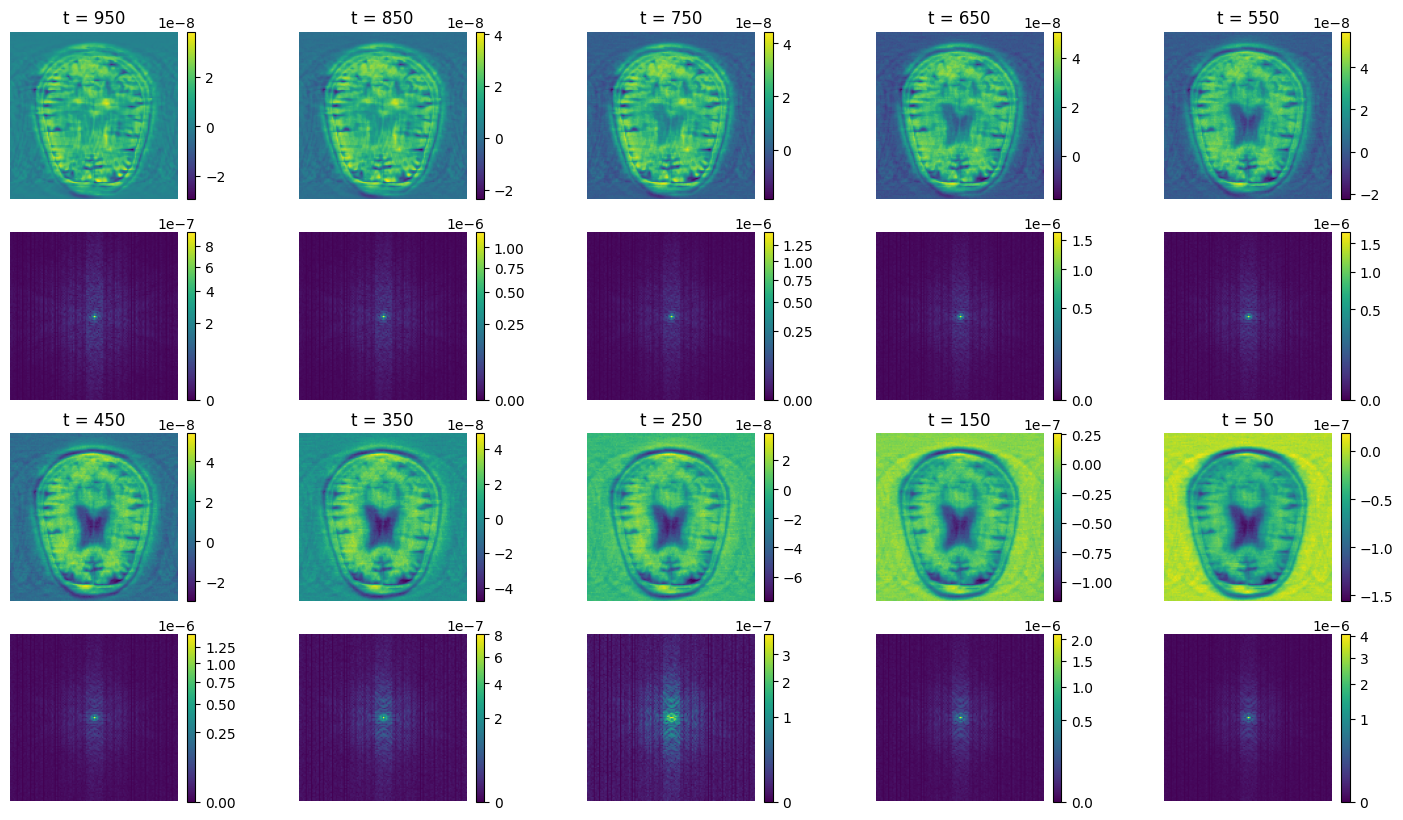

In [48]:
from matplotlib import colors

fig, ax = plt.subplots(4,5, figsize=(18,10))
val = 100
offset = 50
for i,elem in enumerate(data):
    if i%val == offset:
        t = i
        if i<500:
            row = 0
        else:
            row = 2
            i = i - 500
        print(i,t)
        dummy1 = ax[row,i//val].imshow(elem)
        plt.colorbar(dummy1, fraction=0.046, pad=0.04)
        ax[row,i//val].set_title(f"t = {1000 - t}")
        ax[row,i//val].axis("off")

        elem = torch.abs(torch.fft.fftshift(torch.fft.fftn(elem, dim=(0,1), norm="ortho"), dim=(0,1)))
        dummy2 = ax[row+1,i//val].imshow(elem, norm=colors.PowerNorm(0.5))
        plt.colorbar(dummy2, fraction=0.046, pad=0.04, )
        ax[row+1,i//val].axis("off")
        i = t

In [4]:
import h5py
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from jaxtyping import Float
from torch import Tensor
from torch.fft import ifftn
import string
from torch.nn.functional import mse_loss
from matplotlib import colors

def to_imgspace(kspace: Float[Tensor, "batch 2 height width"]) -> Float[Tensor, "batch 1 height width"]:
    kspace = torch.view_as_complex(kspace.permute(0,2,3,1).contiguous())
    img = ifftn(kspace, norm="ortho", dim=(1,2))
    img = torch.view_as_real(img).permute(0,3,1,2)
    return torch.norm(img, dim=1, keepdim=True)

masks = []
mask_images = []
guidance = []
losses = []
mse = []
results = []
accelerations = []
type = []

originals = None
corrupted = []

with h5py.File("/home/peerli/net_scratch/direct_samples.h5", "r") as f:
    originals = torch.from_numpy(f["samples"][()])
    for mask in ["mask0","mask1","mask2"]:
        mask_images.append(torch.from_numpy(f[mask]["mask"][()]))
        corrupted.append(to_imgspace(torch.from_numpy(f[mask]["corrupted_kspace"][()])))
        keys = [int(elem) for elem in f[mask]["reconstruction"]["direct"].keys()]
        for elem in keys:
            dummy = f[mask]["reconstruction"]["direct"][str(elem)]
            masks.append(mask)
            guidance.append(dummy["guidance_factor"][()])
            losses.append(dummy["losses"][()])
            mse.append(dummy["mse"][()])
            results.append(torch.from_numpy(dummy["results"][()]))
            accelerations.append(f[mask]["effective_acceleration"][()])
            type.append("direct")
            
df = pd.DataFrame({
        "mask": masks,
        "guidance": guidance,
        "losses": losses,
        "compute": [len(elem) for elem in losses],
        "mse": mse,
        "acc": accelerations
    })

In [5]:
df.sort_values(["mask","mse"])

mask  guidance                                             losses  \
9   mask0    200000  [0.57956433, 0.8611057, 0.6262879, 0.46813473,...   
8   mask0    100000  [0.57927746, 0.6490932, 0.5162163, 0.45806974,...   
7   mask0     50000  [0.57812226, 0.7054183, 0.5746993, 0.53005725,...   
6   mask0     30000  [0.57896096, 0.72214, 0.5985773, 0.56027126, 0...   
5   mask0     20000  [0.5783652, 0.7338843, 0.61034644, 0.5756023, ...   
4   mask0     10000  [0.5794242, 0.7342259, 0.61696744, 0.588189, 0...   
3   mask0      5000  [0.57858056, 0.73828965, 0.62205935, 0.5958371...   
2   mask0      3000  [0.5785227, 0.74119055, 0.6246022, 0.59961534,...   
1   mask0      2000  [0.57781714, 0.74001324, 0.62421423, 0.5992703...   
0   mask0      1000  [0.5769288, 0.7415285, 0.62705314, 0.6027543, ...   
19  mask1    200000  [0.6297412, 6.4425173, 1.356894, 0.47147256, 0...   
18  mask1    100000  [0.62989366, 0.7988021, 0.62432337, 0.49187854...   
17  mask1     50000  [0.6332945, 0.7164315, 0.5704601, 0.5082815, 0...   
16  mask1     30000  [0.6286483, 0.7690546, 0.6236046, 0.57052886, ...   
15  mask1     20000  [0.6300521, 0.7971673, 0.651876, 0.6040834, 0....   
14  mask1     10000  [0.6302864, 0.8164724, 0.67855066, 0.6379837, ...   
13  mask1      5000  [0.6316813, 0.8273968, 0.6860816, 0.6502063, 0...   
12  mask1      3000  [0.6283367, 0.8305901, 0.69325095, 0.6574918, ...   
11  mask1      2000  [0.62928313, 0.8298368, 0.69459915, 0.6616755,...   
10  mask1      1000  [0.6296443, 0.83517164, 0.6970751, 0.6636082, ...   
29  mask2    200000  [0.7444691, 88.38681, 4.830948, 0.7216728, 0.2...   
27  mask2     50000  [0.74306905, 1.0758147, 0.8117157, 0.5861292, ...   
26  mask2     30000  [0.74380434, 0.74522346, 0.571341, 0.4967507, ...   
28  mask2    100000  [0.7432243, 11.901163, 1.9961495, 0.537237, 0....   
25  mask2     20000  [0.74058455, 0.8579882, 0.66991943, 0.5930509,...   
24  mask2     10000  [0.7453464, 0.98619896, 0.78537863, 0.71723145...   
23  mask2      5000  [0.7476715, 1.0253408, 0.8338482, 0.7666919, 0...   
22  mask2      3000  [0.7467493, 1.0399313, 0.8428322, 0.78612685, ...   
21  mask2      2000  [0.7472811, 1.0540092, 0.85436845, 0.8024344, ...   
20  mask2      1000  [0.7422193, 1.0542, 0.8543282, 0.8050625, 0.78...   

    compute       mse        acc  
9       999  0.000319   3.121951  
8       999  0.000386   3.121951  
7       999  0.000506   3.121951  
6       999  0.000638   3.121951  
5       999  0.000781   3.121951  
4       999  0.001167   3.121951  
3       999  0.001873   3.121951  
2       999  0.003079   3.121951  
1       999  0.005222   3.121951  
0       999  0.012134   3.121951  
19      999  0.001093   5.565217  
18      999  0.001194   5.565217  
17      999  0.001302   5.565217  
16      999  0.001497   5.565217  
15      999  0.001635   5.565217  
14      999  0.002102   5.565217  
13      999  0.002922   5.565217  
12      999  0.003998   5.565217  
11      999  0.005448   5.565217  
10      999  0.010411   5.565217  
29      999  0.005158  11.636364  
27      999  0.005176  11.636364  
26      999  0.005260  11.636364  
28      999  0.005333  11.636364  
25      999  0.005339  11.636364  
24      999  0.005968  11.636364  
23      999  0.006449  11.636364  
22      999  0.007086  11.636364  
21      999  0.008220  11.636364  
20      999  0.010522  11.636364

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 128, 128]) torch.Size([100, 1, 128, 128])
torch.Size([1, 1, 128, 128]) torch.Size([100, 1, 128, 128])
torch.Size([1, 1, 128, 128]) torch.Size([100, 1, 128, 128])


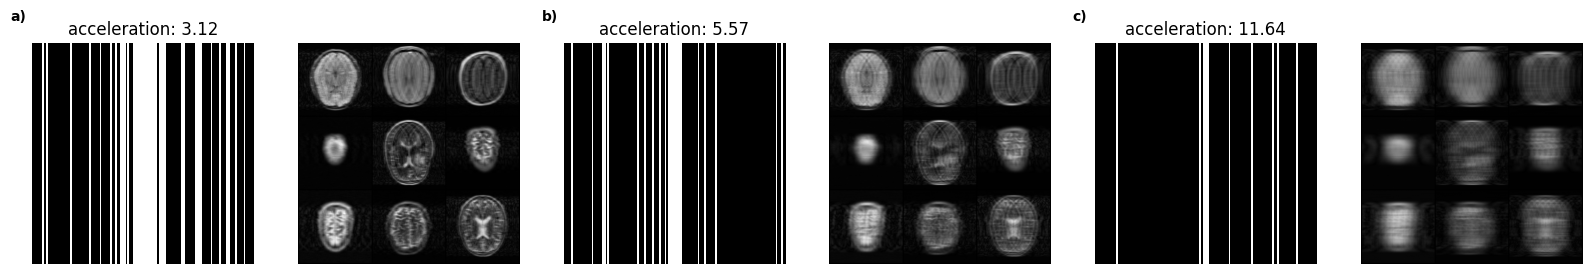

In [6]:
fig, ax = plt.subplots(1,6, figsize=(20,3))
for i,(mask,corr) in enumerate(zip(mask_images,corrupted)):
    print(mask.shape, corr.shape)
    ax[i*2].imshow(mask[0].permute(1,2,0), interpolation="none", cmap="gray")
    ax[i*2+1].imshow(make_grid(corr[::12], nrow=3).permute(1,2,0))
    ax[i*2].set_title(f"acceleration: {sorted(df.acc.unique().tolist())[i]:.2f}")

for n,elem in enumerate(ax):
    elem.axis("off")
    if n%2==0:
        elem.text(-0.1, 1.1, string.ascii_lowercase[n//2]+")", transform=elem.transAxes, size=10, weight='bold')

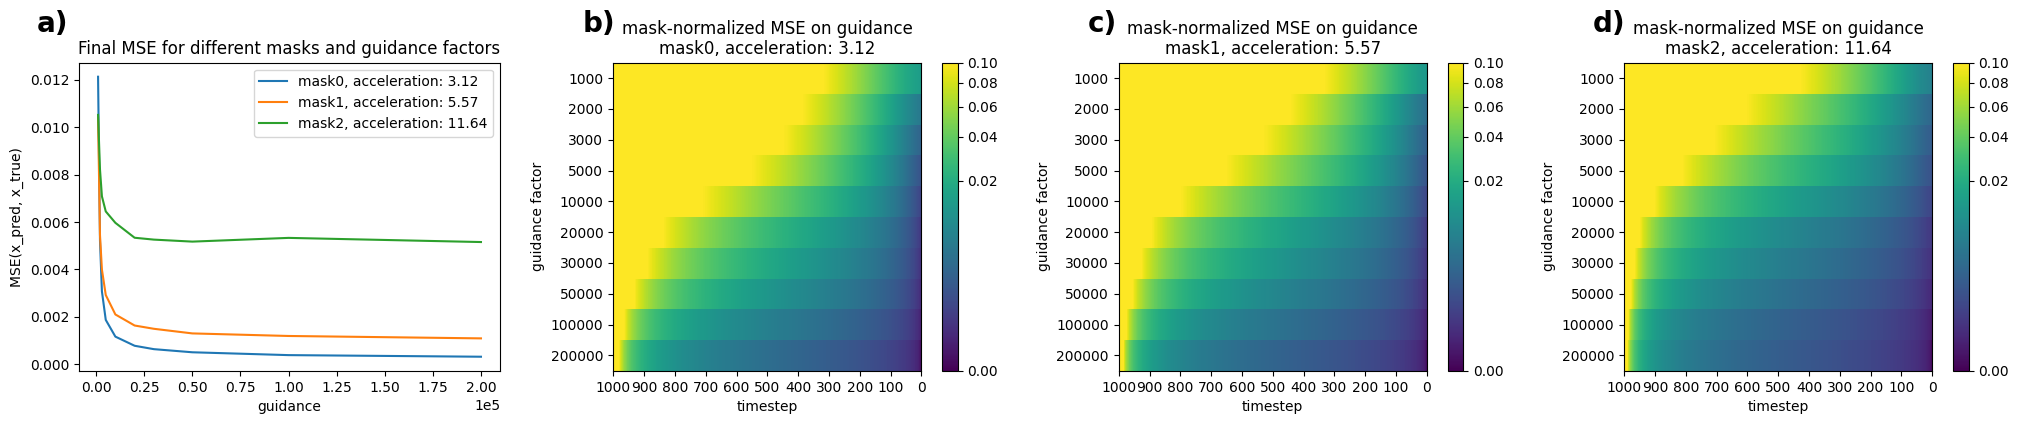

In [7]:
#plt.rcParams['text.usetex'] = True
fig, ax = plt.subplots(1,4, figsize=(25,4))
for i,mask in enumerate(df["mask"].unique()):
    acceleration = df[df['mask']==mask].acc.values[0]
    df[df["mask"]==mask].set_index("guidance").mse.plot(ax=ax[0], label=f"{mask}, acceleration: {acceleration:.2f}")
    ax[0].set_title("Final MSE for different masks and guidance factors")
    ax[0].set_ylabel("MSE(x_pred, x_true)")
    ax[0].ticklabel_format(style="sci", axis="x", scilimits=(0,0))
    losses = torch.stack([torch.tensor(elem) for elem in df[df["mask"]==mask].losses.values])
    # losses = torch.log(losses)
    k = ax[i+1].imshow(
            losses, 
            aspect=100, 
            # vmax=0.1, 
            interpolation="none",
            norm=colors.PowerNorm(0.3, vmax=0.1)
        )
    ax[i+1].set_title(f"mask-normalized MSE on guidance\n{mask}, acceleration: {acceleration:.2f}")
    ax[i+1].set_yticks(range(len(df[df["mask"]==mask].guidance.values)), labels=df[df["mask"]==mask].guidance.values)
    ax[i+1].set_xticks(list(reversed(range(0,1001,100))), labels=list(range(0,1001,100)))
    ax[i+1].set_xlabel("timestep")
    ax[i+1].set_ylabel("guidance factor")
    plt.colorbar(k)
    # for elem,g in zip(df[df["mask"]==mask].losses.values, df[df["mask"]==mask].guidance.values):
    #     ax[i+1].plot(elem, label=f"acceleration: {g}")
    #     ax[i+1].legend()
ax[0].legend()

for n,elem in enumerate(ax.reshape(-1)):
    elem.text(-0.1, 1.1, string.ascii_lowercase[n]+")", transform=elem.transAxes, size=20, weight='bold')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


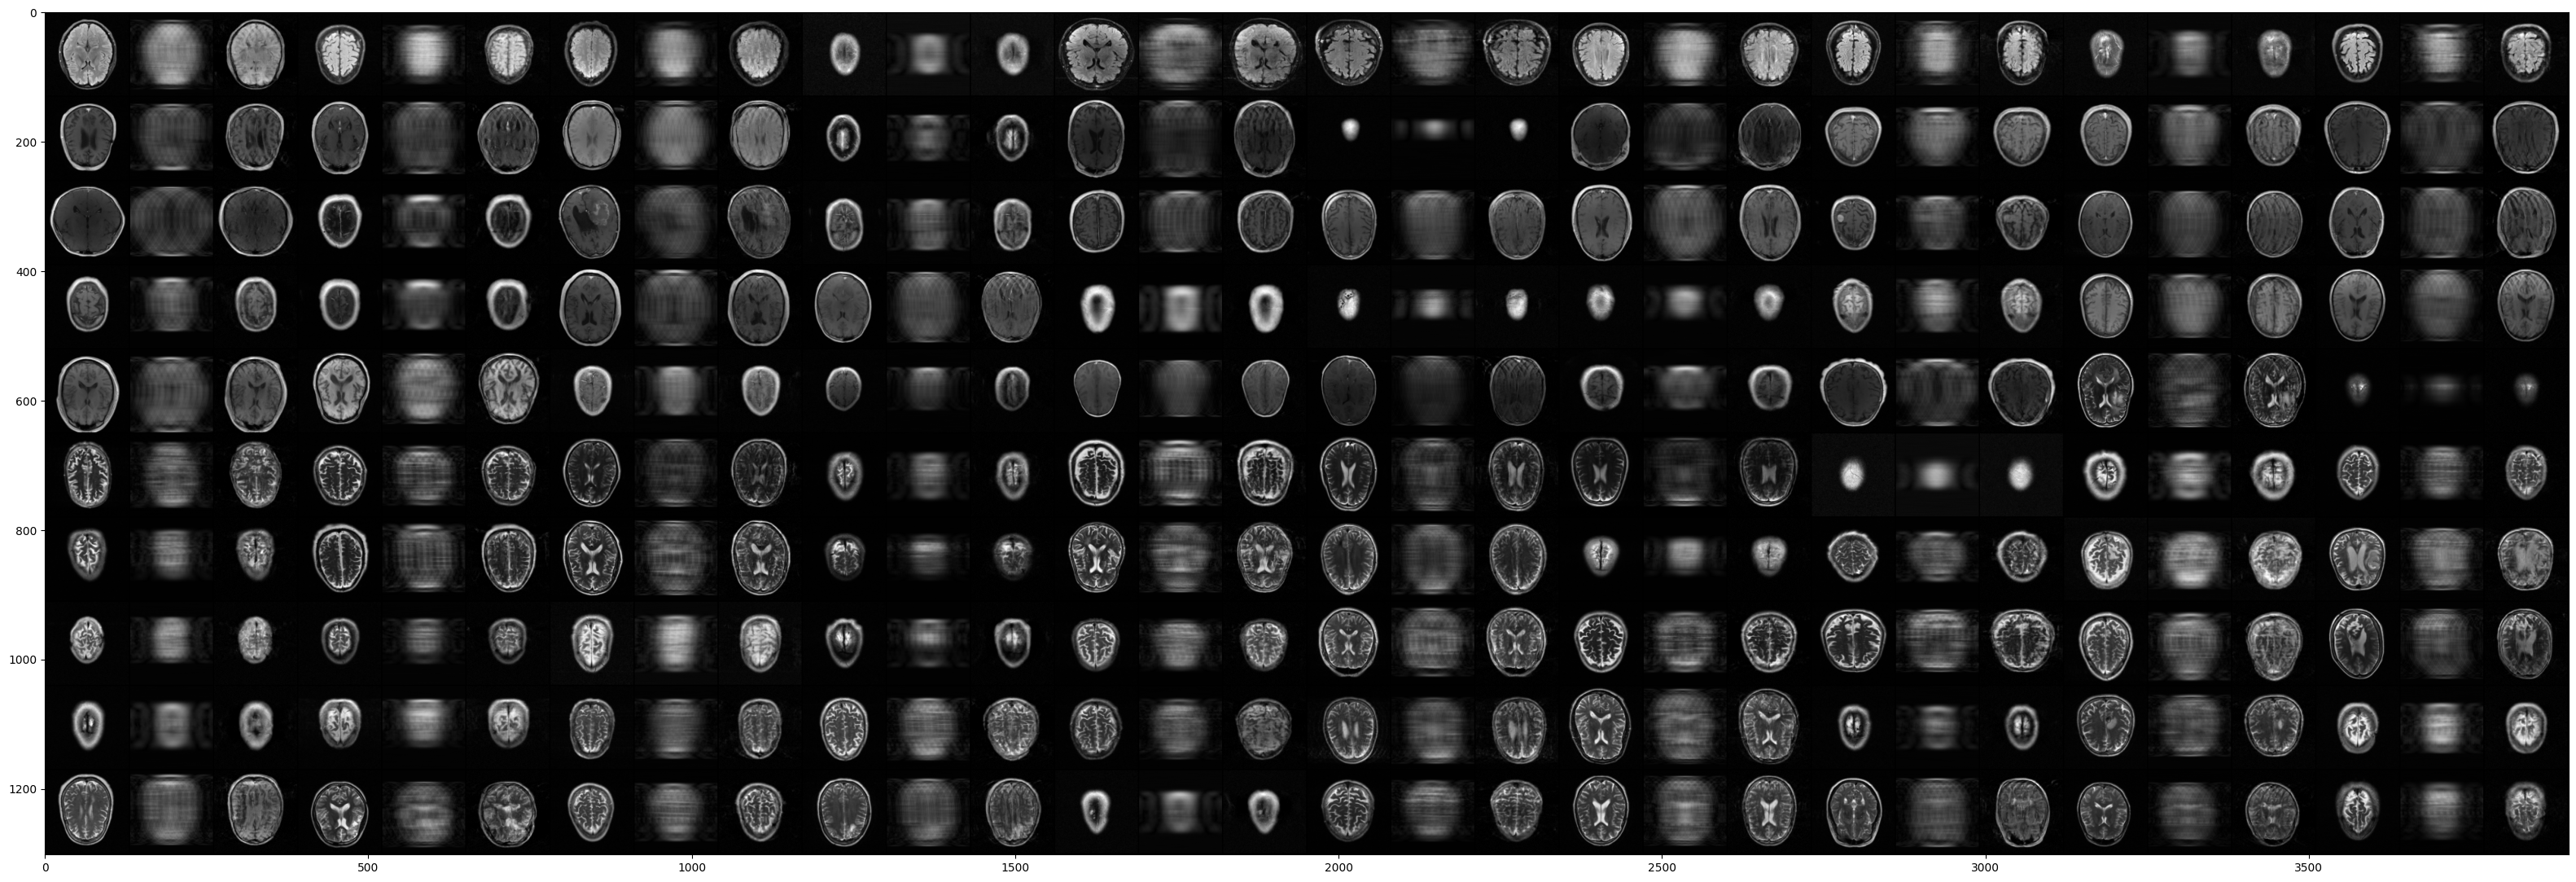

In [8]:
num = 29

if num in range(10):
    mask = 0
elif num in range(10,20):
    mask = 1
else:
    mask = 2

g_factor = guidance[num]
myacc = accelerations[num]
corrupted = corrupted[mask]
results = results[num]

total = torch.zeros((results.shape[0]*3,*results.shape[1:]))
for i in range(results.shape[0]):
    total[i*3] = originals[i]
    total[(i*3)+1] = corrupted[i]
    total[(i*3)+2] = results[i]

fig, ax = plt.subplots(figsize=(40,40))
ax.imshow(make_grid(total, nrow=30).permute(1,2,0))

In [9]:
myfactors

NameError: name 'myfactors' is not defined

In [10]:
subsample.shape

NameError: name 'subsample' is not defined

In [11]:
myfactors

NameError: name 'myfactors' is not defined

In [12]:
myres = torch.stack(results)
subsample = myres[::5,::25]

print(subsample.shape)

myfactors = guidance[::5]
myacc = accelerations[::5]
myorig = originals[::25]

fig, axs = plt.subplots(1,4,figsize=(15,5))
for i,ax in enumerate(axs):
    ax.imshow(make_grid(subsample[:,i], nrow=2).permute(1,2,0))
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.set_xlabel("guidance factor")
    ax.set_xticks([64,64+128], labels=[1000,20000])
    ax.set_yticks([])
axs[0].set_yticks([64,64+128,64+128*2], labels=[f"{accelerations[0]:.2f}",f"{accelerations[2]:.2f}",f"{accelerations[4]:.2f}"])
axs[0].set_ylabel("acceleration")

TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

3
3


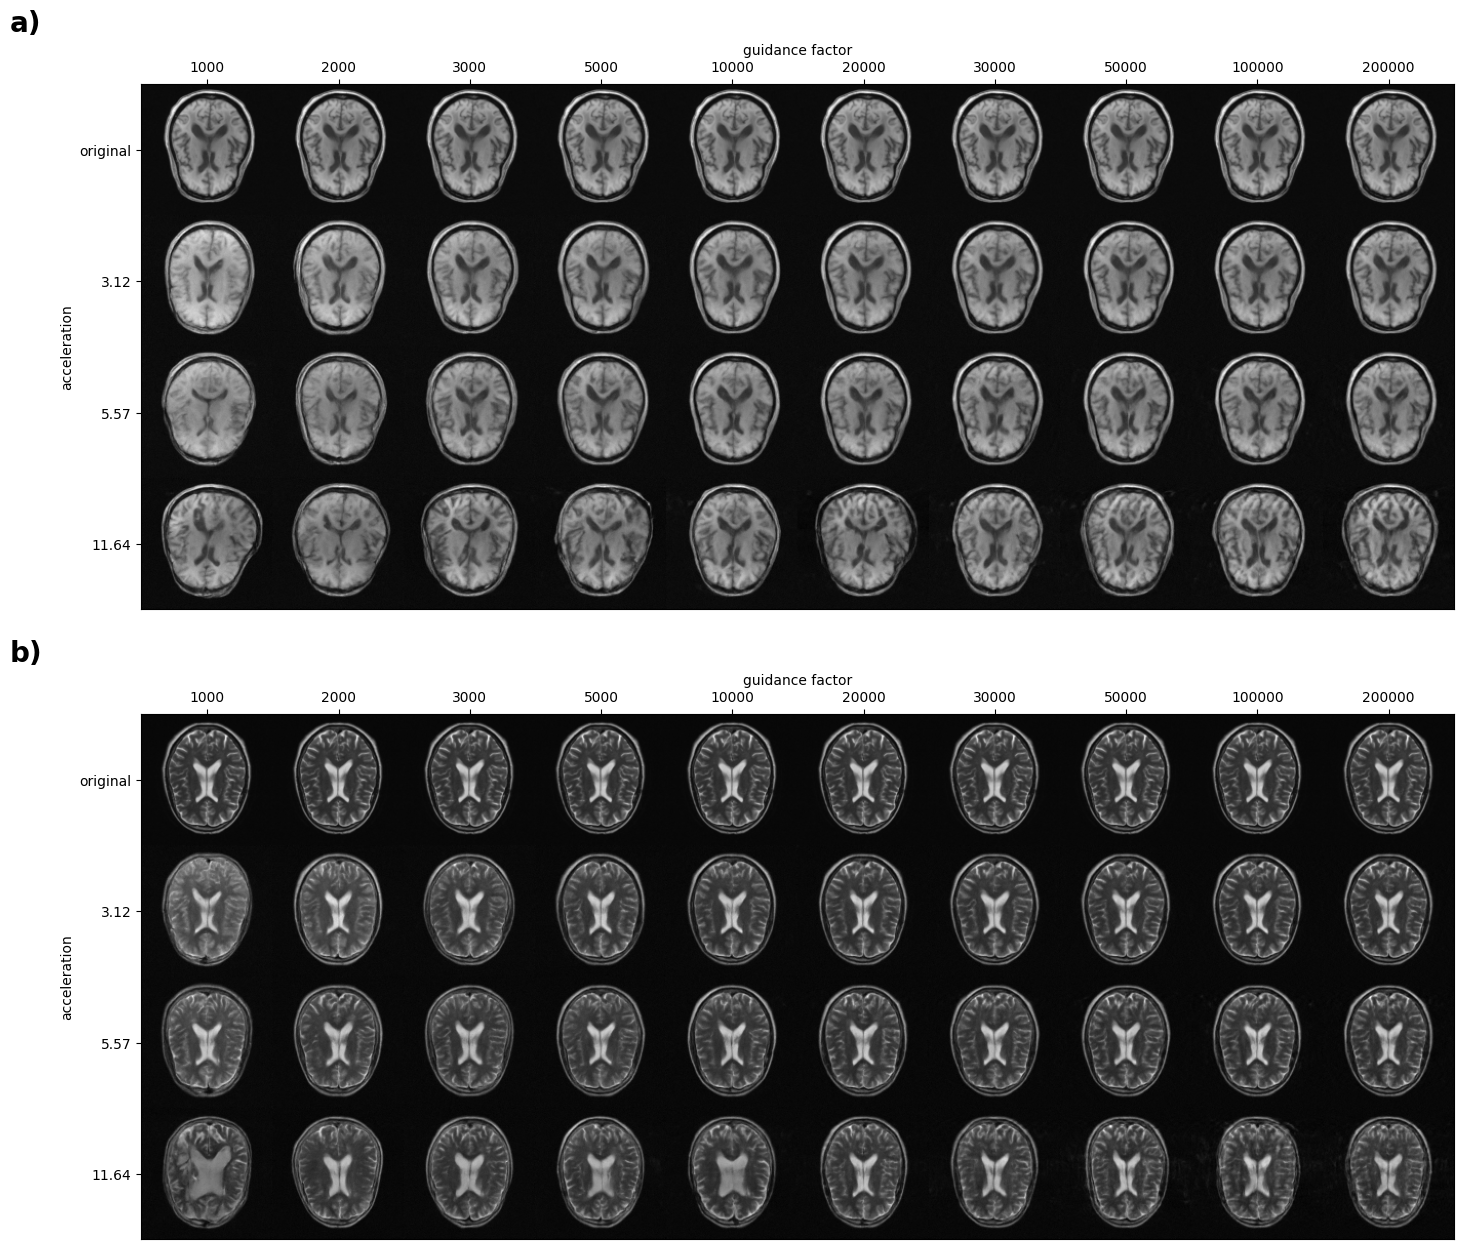

In [13]:
def get_sample_grid(index: int):
    grid = torch.zeros((4*128,10*128))
    accelerations = []
    guidance_results1 = []
    guidance_results2 = []
    guidance_results3 = []
    with h5py.File("/home/peerli/net_scratch/direct_samples.h5", "r") as f:
        grid[:128,:] = torch.from_numpy(f["samples"][()][index][0]).repeat(1,10)
        #print(f.keys())
        for mask in [elem for elem in f.keys()if "mask" in elem]:
            accelerations.append(round(f[mask]["effective_acceleration"][()], 2))
            dummy = f[mask]["reconstruction"]["direct"]
            for elem in dummy.values():
                if mask == "mask0":
                    guidance_results1.append((elem["guidance_factor"][()], torch.from_numpy(elem["results"][()])))
                elif mask == "mask1":
                    guidance_results2.append((elem["guidance_factor"][()], torch.from_numpy(elem["results"][()])))
                elif mask == "mask2":
                    guidance_results3.append((elem["guidance_factor"][()], torch.from_numpy(elem["results"][()])))
    guidance_results1 = sorted(guidance_results1, key=lambda x: x[0])
    guidance_results2 = sorted(guidance_results2, key=lambda x: x[0])
    guidance_results2 = sorted(guidance_results2, key=lambda x: x[0])
    for i,(g,res) in enumerate(guidance_results1):
        grid[128:256,(128*i):128+(128*i)] = res[index][0]
    for i,(g,res) in enumerate(guidance_results2):
        grid[256:256+128,(128*i):128+(128*i)] = res[index][0]
    for i,(g,res) in enumerate(guidance_results3):
        grid[256+128:512,(128*i):128+(128*i)] = res[index][0]
    factors1 = np.array([x[0] for x in guidance_results1])
    factors2 = np.array([x[0] for x in guidance_results2])
    factors3 = np.array([x[0] for x in guidance_results3])
    assert np.array_equal(factors1, factors2) and np.array_equal(factors1, factors3)
    return grid, accelerations, factors1

sample = 96

fig, axs = plt.subplots(2,figsize=(25,15))
for i,(ax,sample) in enumerate(zip(axs,[41,96])):
    grid, acc, fac = get_sample_grid(sample)
    ax.imshow(grid, cmap="gray")
    print(len(acc))
    yticks = ["original"]
    yticks.extend(acc)
    ax.set_yticks([64+(128*i) for i in range(4)], labels=yticks)
    ax.set_ylabel("acceleration")
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.set_xticks([64+(128*i) for i in range(10)], labels=fac)
    ax.set_xlabel("guidance factor")
    ax.text(-0.1, 1.1, string.ascii_lowercase[i]+")", transform=ax.transAxes, size=20, weight='bold')

3
3


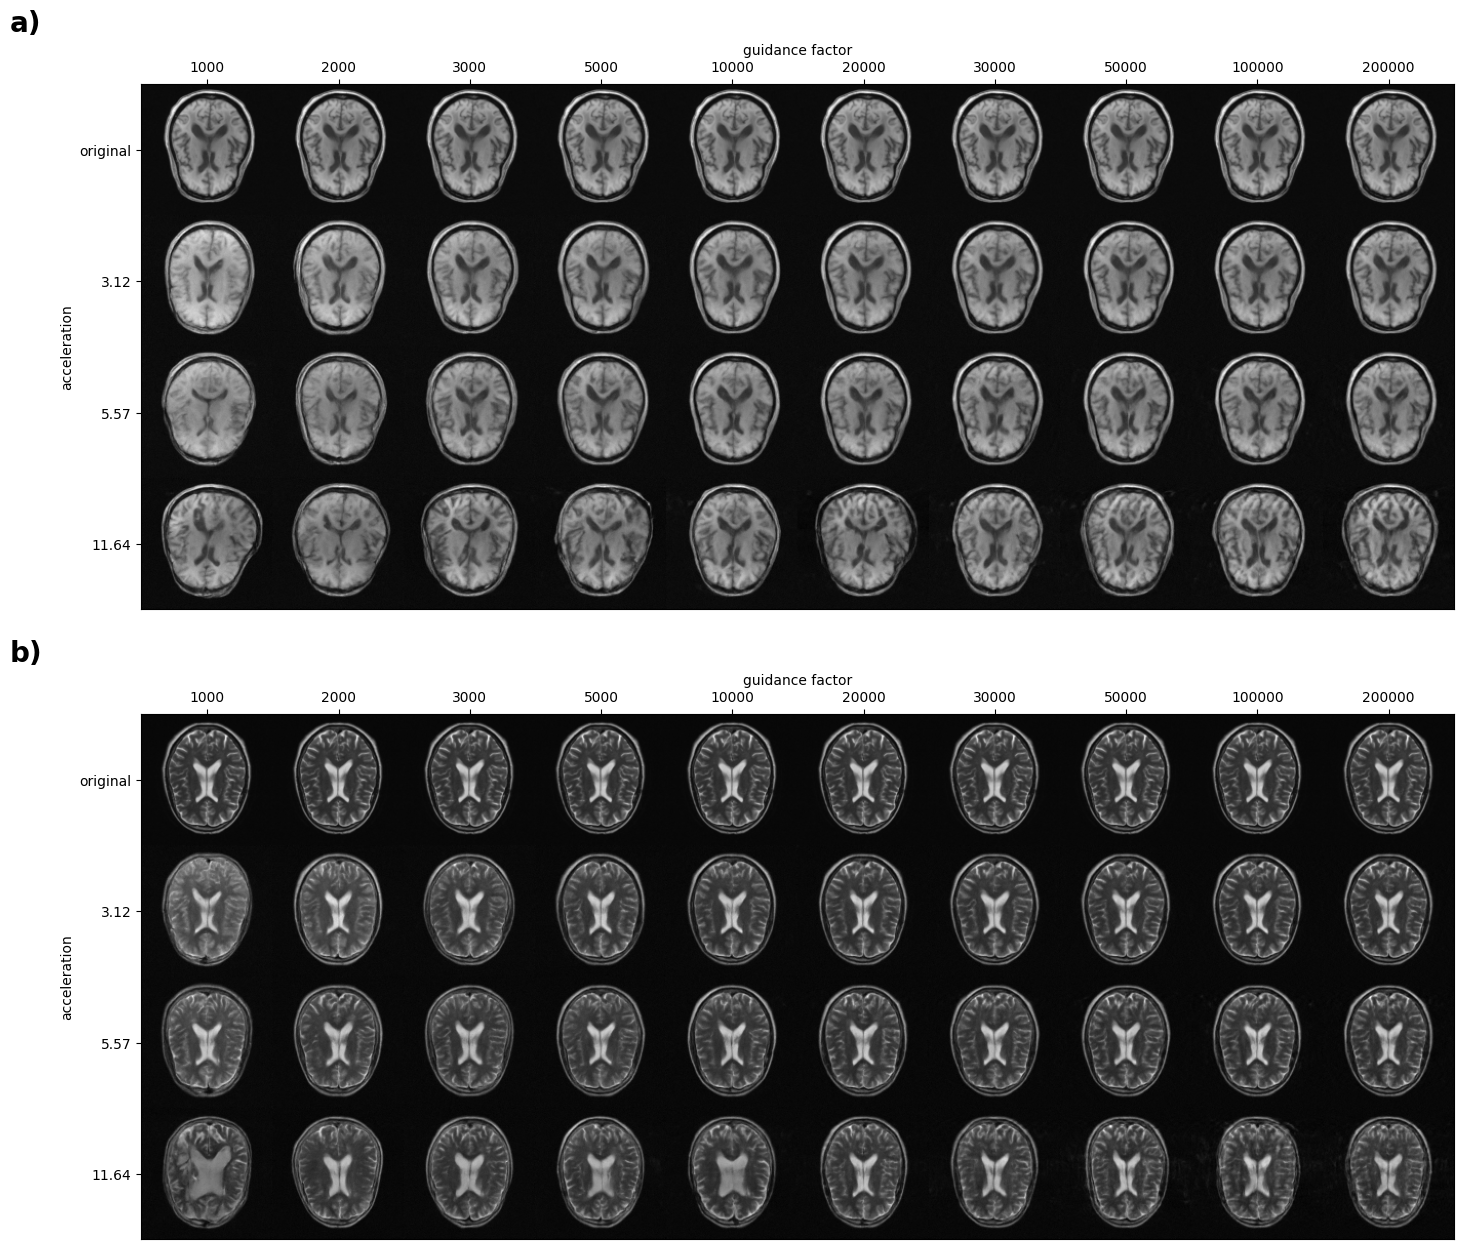

In [25]:
def get_sample_grid(index: int):
    grid = torch.zeros((4*128,2*128))
    accelerations = []
    guidance_results1 = []
    guidance_results2 = []
    guidance_results3 = []
    with h5py.File("/home/peerli/net_scratch/direct_samples.h5", "r") as f:
        grid[:128,:] = torch.from_numpy(f["samples"][()][index][0]).repeat(1,2)
        #print(f.keys())
        for mask in [elem for elem in f.keys()if "mask" in elem]:
            accelerations.append(round(f[mask]["effective_acceleration"][()], 2))
            dummy = f[mask]["reconstruction"]["direct"]
            for elem in dummy.values():
                if elem["guidance_factor"][()] in [20000, 200000]:
                    if mask == "mask0":
                        guidance_results1.append((elem["guidance_factor"][()], torch.from_numpy(elem["results"][()])))
                    elif mask == "mask1":
                        guidance_results2.append((elem["guidance_factor"][()], torch.from_numpy(elem["results"][()])))
                    elif mask == "mask2":
                        guidance_results3.append((elem["guidance_factor"][()], torch.from_numpy(elem["results"][()])))
    guidance_results1 = sorted(guidance_results1, key=lambda x: x[0])
    guidance_results2 = sorted(guidance_results2, key=lambda x: x[0])
    guidance_results2 = sorted(guidance_results2, key=lambda x: x[0])
    for i,(g,res) in enumerate(guidance_results1):
        grid[128:256,(128*i):128+(128*i)] = res[index][0]
    for i,(g,res) in enumerate(guidance_results2):
        grid[256:256+128,(128*i):128+(128*i)] = res[index][0]
    for i,(g,res) in enumerate(guidance_results3):
        grid[256+128:512,(128*i):128+(128*i)] = res[index][0]
    factors1 = np.array([x[0] for x in guidance_results1])
    factors2 = np.array([x[0] for x in guidance_results2])
    factors3 = np.array([x[0] for x in guidance_results3])
    assert np.array_equal(factors1, factors2) and np.array_equal(factors1, factors3)
    return grid, accelerations, factors1

sample = 96

fig, axs = plt.subplots(2,figsize=(25,15))
for i,(ax,sample) in enumerate(zip(axs,[41,96])):
    grid, acc, fac = get_sample_grid(sample)
    ax.imshow(grid, cmap="gray")
    print(len(acc))
    yticks = ["original"]
    yticks.extend(acc)
    ax.set_yticks([64+(128*i) for i in range(4)], labels=yticks)
    ax.set_ylabel("acceleration")
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.set_xticks([64+(128*i) for i in range(10)], labels=fac)
    ax.set_xlabel("guidance factor")
    ax.text(-0.1, 1.1, string.ascii_lowercase[i]+")", transform=ax.transAxes, size=20, weight='bold')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

torch.Size([10, 4, 1, 128, 128]) 10 10 torch.Size([4, 1, 128, 128])


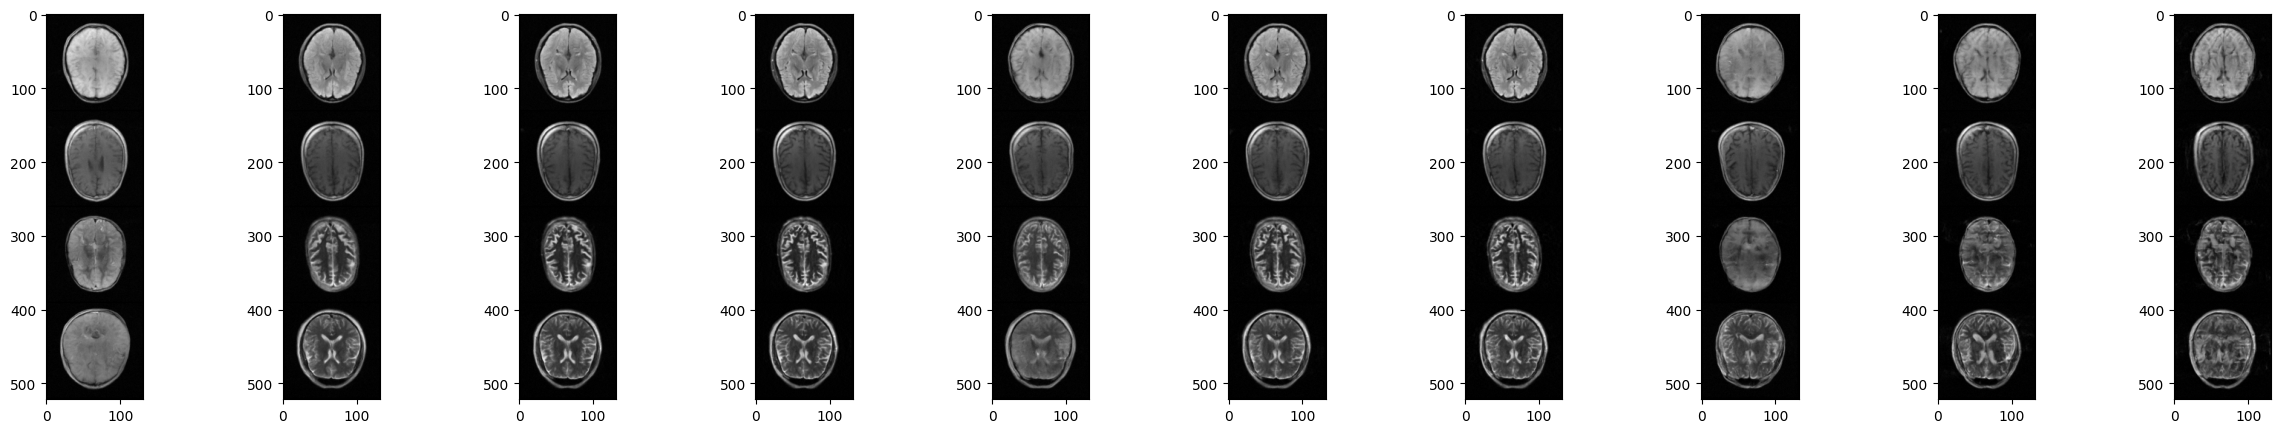

In [136]:
myres = torch.stack(results)
subsample = myres[::3,::25]

myfactors = guidance[::3]
myacc = accelerations[::3]
myorig = originals[::25]

print(subsample.shape, len(myfactors), len(myacc), myorig.shape)

fig, axs = plt.subplots(1,10, figsize=(30,5))
for i,ax in enumerate(axs.reshape(-1)):
    ax.imshow(make_grid(subsample[i],nrow=1).permute(1,2,0))

In [207]:
import context
from utils.datasets import FastMRIBrainTrain, MNISTTrainDataset, Cifar10Dataset

print(len(FastMRIBrainTrain("/itet-stor/peerli/bmicdatasets-originals/Originals/fastMRI/brain/multicoil_train")), len(MNISTTrainDataset(root="/home/peerli/net_scratch/")), len(Cifar10Dataset(root="/home/peerli/net_scratch/")))

Files already downloaded and verified
60090 60000 50000


In [12]:
import h5py
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from jaxtyping import Float
from torch import Tensor
from torch.fft import ifftn
import string
from torch.nn.functional import mse_loss
from matplotlib import colors

def to_imgspace(kspace: Float[Tensor, "batch 2 height width"]) -> Float[Tensor, "batch 1 height width"]:
    kspace = torch.view_as_complex(kspace.permute(0,2,3,1).contiguous())
    img = ifftn(kspace, norm="ortho", dim=(1,2))
    img = torch.view_as_real(img).permute(0,3,1,2)
    return torch.norm(img, dim=1, keepdim=True)

mse = []
slowdown = []
guidance = []
masks = []

with h5py.File("/home/peerli/net_scratch/slowDown_samples.h5", "r") as f:
    originals = torch.from_numpy(f["samples"][()])
    for mask in ["mask0","mask1","mask2"]:
        file = f[mask]["reconstruction"]["slowingDown"]
        for elem in sorted([int(val) for val in file.keys()]):
            elem = file[str(elem)]
            mse.append(elem["mse"][()])
            slowdown.append(elem["slowdown_factor"][()])
            guidance.append(elem["guidance_factor"][()])
            masks.append(mask)

df = pd.DataFrame(
    {
        "mask":masks,
        "mse":mse,
        "slowdown":slowdown,
        "guidance": guidance,
        "compute": np.array(slowdown) * 1000,
        "eff_guidance": np.round(np.array(slowdown) * np.array(guidance), -3)
    }
)

In [13]:
df = df.sort_values(["slowdown","eff_guidance"])

In [14]:
mask0 = df[df["mask"]=="mask0"]
mask1 = df[df["mask"]=="mask1"]
mask2 = df[df["mask"]=="mask2"]

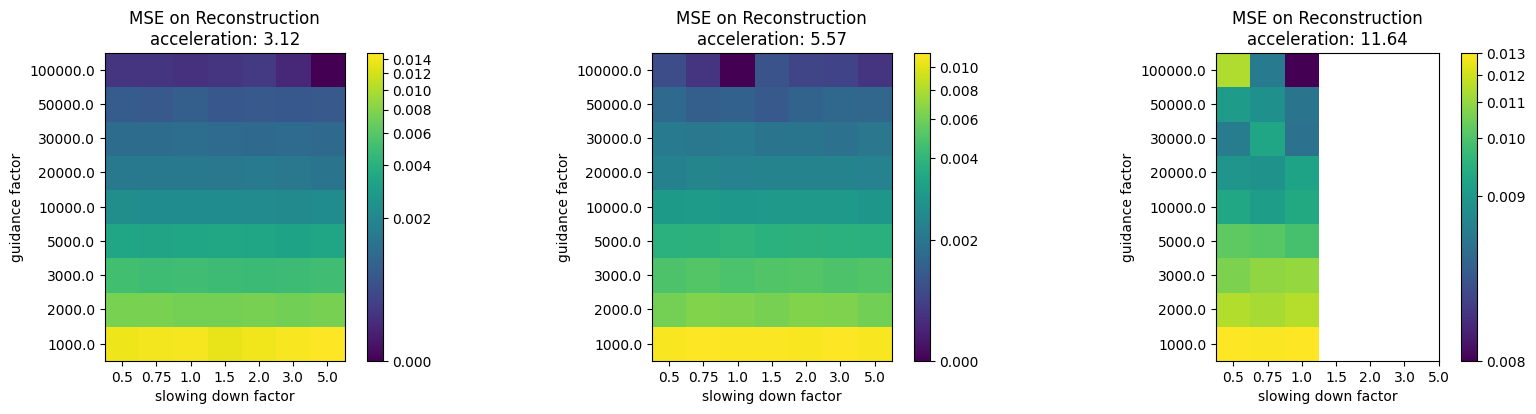

In [34]:
from matplotlib import colors

acc = [3.12, 5.57, 11.64]

fig, axs = plt.subplots(1,3, figsize=(20,4))
for i,ax in enumerate(axs):
    if i == 0:
        dummy = df[df["mask"]=="mask0"]
        k = ax.imshow(dummy.mse.values.reshape(7,9).transpose(1,0), origin="lower", norm=colors.PowerNorm(0.3), interpolation="none")
    elif i==1:
        dummy = df[df["mask"]=="mask1"]
        k = ax.imshow(dummy.mse.values.reshape(7,9).transpose(1,0), origin="lower", norm=colors.PowerNorm(0.3), interpolation="none")
    elif i==2:
        dummy = df[(df["mask"]=="mask2")&(df.slowdown.isin([.5,.75,1.]))]
        k = ax.imshow(dummy.mse.values.reshape(3,9).transpose(1,0), origin="lower", norm=colors.PowerNorm(0.3), interpolation="none")
    plt.colorbar(k)
    ax.set_title(f"MSE on Reconstruction\nacceleration: {acc[i]}")
    ax.set_yticks(np.arange(9), [1000.,2000.,3000.,5000.,10000.,20000.,30000.,50000.,100000.])
    ax.set_xticks(np.arange(7), [0.5, 0.75,1.,1.5,2.,3.,5.])
    ax.set_ylabel("guidance factor")
    ax.set_xlabel("slowing down factor")

In [13]:
import h5py
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from jaxtyping import Float
from torch import Tensor
from torch.fft import ifftn
import string
from torch.nn.functional import mse_loss
from matplotlib import colors

def to_imgspace(kspace: Float[Tensor, "batch 2 height width"]) -> Float[Tensor, "batch 1 height width"]:
    kspace = torch.view_as_complex(kspace.permute(0,2,3,1).contiguous())
    img = ifftn(kspace, norm="ortho", dim=(1,2))
    img = torch.view_as_real(img).permute(0,3,1,2)
    return torch.norm(img, dim=1, keepdim=True)

mse = []
jumps = []
guidance = []
masks = []

with h5py.File("/home/peerli/net_scratch/longRes_samples.h5", "r") as f:
    originals = torch.from_numpy(f["samples"][()])
    for mask in ["mask0","mask1","mask2"]:
        if "reconstruction" in f[mask].keys():
            file = f[mask]["reconstruction"]["globalResampling"]
            for elem in sorted([int(val) for val in file.keys()]):
                elem = file[str(elem)]
                mse.append(elem["mse"][()])
                guidance.append(elem["guidance_factor"][()])
                jumps.append(elem["jump_length"][()])
                masks.append(mask)

df = pd.DataFrame(
    {
        "mask":masks,
        "mse":mse,
        "jumps":jumps,
        "guidance": guidance,
        #"compute": 1000//np.array(jumps),
        #"eff_guidance": np.round(np.array(slowdown) * np.array(guidance), -3)
    }
)

In [18]:
pd.set_option("display.max_rows",100)
df = df[df.jumps>50]
df = df[df.guidance<30000]

In [19]:
df

mask       mse  jumps  guidance
0   mask0  0.012762    500      1000
1   mask0  0.013316    200      1000
2   mask0  0.010091    100      1000
6   mask0  0.004898    500      2000
7   mask0  0.003829    200      2000
8   mask0  0.003295    100      2000
12  mask0  0.002940    500      3000
13  mask0  0.002479    200      3000
14  mask0  0.002229    100      3000
18  mask0  0.001898    500      5000
19  mask0  0.001708    200      5000
20  mask0  0.001525    100      5000
24  mask0  0.001220    500     10000
25  mask0  0.001088    200     10000
26  mask0  0.000999    100     10000
30  mask0  0.000834    500     20000
31  mask0  0.000754    200     20000
32  mask0  0.000685    100     20000
37  mask1  0.009658    500      1000
38  mask1  0.008674    200      1000
39  mask1  0.007949    100      1000
43  mask1  0.005816    500      2000
44  mask1  0.005036    200      2000
45  mask1  0.004435    100      2000
49  mask1  0.004294    500      3000
50  mask1  0.003672    200      3000
51  mask1  0.003185    100      3000
55  mask1  0.003127    500      5000
56  mask1  0.002634    200      5000
57  mask1  0.002309    100      5000
61  mask1  0.002275    500     10000
62  mask1  0.001872    200     10000
63  mask1  0.001611    100     10000
67  mask1  0.001798    500     20000
68  mask1  0.001452    200     20000
69  mask1  0.001227    100     20000

In [46]:
df = df[df.guidance!=30000]

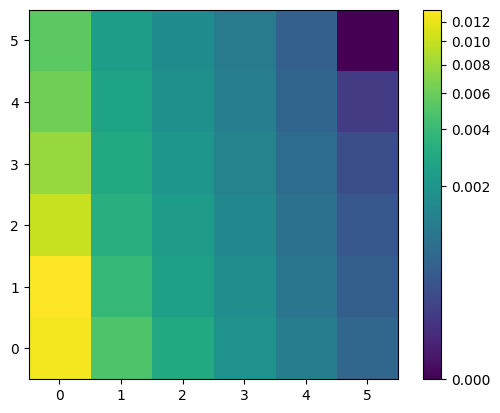

In [54]:
fig, ax = plt.subplots()
k = ax.imshow(df.mse.values.reshape(6,6).transpose(1,0), origin="lower", interpolation="none", norm=colors.PowerNorm(0.3))
plt.colorbar(k)

In [61]:
import h5py
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from jaxtyping import Float
from torch import Tensor
from torch.fft import ifftn
import string
from torch.nn.functional import mse_loss
from matplotlib import colors

def to_imgspace(kspace: Float[Tensor, "batch 2 height width"]) -> Float[Tensor, "batch 1 height width"]:
    kspace = torch.view_as_complex(kspace.permute(0,2,3,1).contiguous())
    img = ifftn(kspace, norm="ortho", dim=(1,2))
    img = torch.view_as_real(img).permute(0,3,1,2)
    return torch.norm(img, dim=1, keepdim=True)

mse = []
jumps = []
guidance = []
masks = []
resamplings = []

with h5py.File("/home/peerli/net_scratch/shortRes_samples.h5", "r") as f:
    originals = torch.from_numpy(f["samples"][()])
    for mask in ["mask0","mask1","mask2"]:
        if "reconstruction" in f[mask].keys():
            file = f[mask]["reconstruction"]["localResampling"]
            for elem in sorted([int(val) for val in file.keys()]):
                elem = file[str(elem)]
                mse.append(elem["mse"][()])
                # print(elem.keys())
                guidance.append(elem["guidance_factor"][()])
                jumps.append(elem["jump_length"][()])
                resamplings.append(elem["num_resamplings"][()])
                masks.append(mask)

df = pd.DataFrame(
    {
        "mask":masks,
        "mse":mse,
        "jumps":jumps,
        "guidance": guidance,
        "resamplings":resamplings
        #"compute": 1000//np.array(jumps),
        #"eff_guidance": np.round(np.array(slowdown) * np.array(guidance), -3)
    }
)

In [64]:
pd.set_option("display.max_rows", 100)
df = df[df.guidance!=3000]

In [74]:
dummy = df.mse.values.reshape(2, 6, 4)

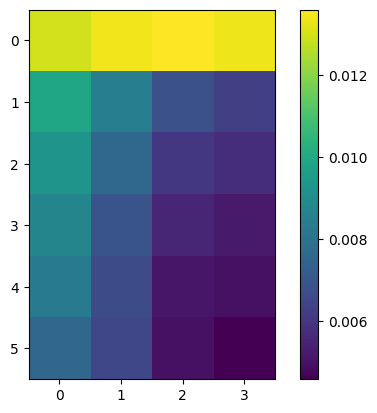

In [76]:
plt.imshow(dummy[0])
plt.colorbar()

[500, 400, 300, 200, 100]


Text(0, 0.5, 'diffusion time')

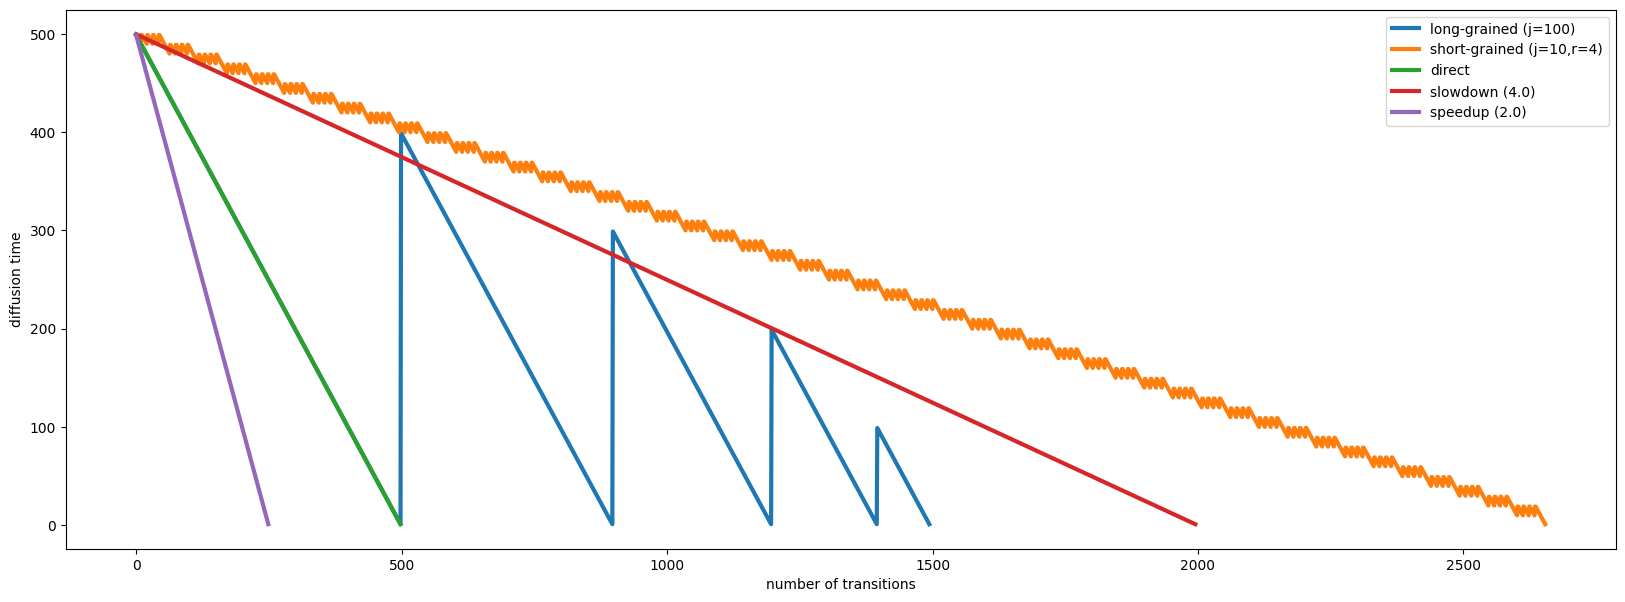

In [5]:
import numpy as np
import matplotlib.pyplot as plt

total = 500

direct = [i for i in reversed(range(1,total))]

long_grained = []
starts = [total-i*100 for i in range(total//100)]
print(starts)
for start in starts:
    for i in reversed(range(1,start)):
        long_grained.append(i)

short_grained = []
for i in reversed(range(1, total)):
    short_grained.append(i)
    if i % 10 == 0:
        for _ in range(4):
            short_grained.append(i-1+10)
            for j in reversed(range(i, i+10)):
                short_grained.append(j)

slowdown = [i for i in reversed(np.arange(1,total,0.25))]
speedup = [i for i in reversed(np.arange(1,total,2))]

seq = [long_grained, short_grained, direct, slowdown, speedup]

fig, ax = plt.subplots(figsize=(20,7))
for i,(el, label) in enumerate(zip(seq,["long-grained (j=100)","short-grained (j=10,r=4)","direct","slowdown (4.0)","speedup (2.0)"])):
    ax.plot(el, label=label, linewidth=3.0)
ax.legend()
ax.set_xlabel("number of transitions")
ax.set_ylabel("diffusion time")